# Importing packages

In [66]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma


In [67]:
import sys
# sys.path.append('/Users/chriskieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [68]:
import pickle

In [69]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [70]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "Mistic2_descFits" #what data did you put in
fileName_common = "_linear" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_250225_v1" #date and versioning

saving_dirrectory = "012 Processed Data"
if not os.path.exists(saving_dirrectory):
    os.mkdir(saving_dirrectory)
    
makingFolder = makeFolderPathForData(parent_dir = saving_dirrectory, 
                                     folderName_header = "Mistic2_descFits_linear_", 
                                     folderName_common= "250225_", 
                                     folderName_suffix = "v1")

dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder 


In [71]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [72]:
#parameters of SVM 
red_factor = 0.1

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

rank_weights = [0,0.25,0.50,0.75,1]

# importing our data

In [73]:
dataFileName = "AL-KnownPts_CompLabswoEcho_exG01J01_MDfits_1Sheet_20241022_v1.xlsx"

In [74]:
# dataFileName = "AL-KnownPts_CompLabs_descFits_241022.xlsx"

In [75]:
# Import dataset
dataTable = pd.read_excel(dataFileName, header = 0) #the dataset we are using

#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'Amyloid Status_yes', 'Amyloid Status_no', "Amyloid Status_unk"]

#columns to use for the y data 
y_column_Classification = 'Amyloid Status_yes'

X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)

binary_feats = []
for col in X.columns:
    unique_values = X[col].unique()
    if len(unique_values) == 2:
        binary_feats.append(X.columns.get_loc(col))
X.iloc[:,binary_feats]    

,Dx_MGUS,Dx_MM,Dx_other,Sex_female,Sex_male,Nucleated RBC Result Desc mean,Nucleated RBC Result Desc std,Nucleated RBC Result Desc 75%,Nucleated RBC Result Desc max,Serum Electrophoresis Alpha 1 Result Desc min,Serum Electrophoresis Alpha 1 Result Desc 25%,Serum Electrophoresis Alpha 1 Result Desc 50%,ChemoTx,ImmunoTx,HemeTx,HemeTx Number,RadTx,RadTx Number,OtherTx,OtherTx Number
0,1,0,0,0,1,0.000000,0.000000,0.00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0
2,1,0,0,0,1,0.000000,0.000000,0.00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0.000000,0.000000,0.00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0.000000,0.000000,0.00,0,0.0,0.0,0.0,1,0,1,1,0,0,0,0
5,0,1,0,1,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
6,0,1,0,1,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0,1,1,0,0,0,0,0,0
7,1,0,0,0,1,0.000000,0.000000,0.00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
8,0,1,0,1,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0,1,1,0,0,0,0,0,0
9,0,1,0,1,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0


In [76]:
X.shape[1]

641

# Setting up classifier

## Scaling data and defining test set

In [77]:
scaler = StandardScaler()
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= 0, 
                                                    test_size= test_size_numb)

max(X_all[:,0])

1.3228756555322954

In [78]:
df_x_train = pd.DataFrame(X_train)
print(type(df_x_train))

<class 'pandas.core.frame.DataFrame'>


In [79]:
df_x_train = pd.DataFrame(X_train)

df_x_test = pd.DataFrame(X_test)

df_y_train = pd.DataFrame(y_train)

df_y_test = pd.DataFrame(y_test)

outputToExcel(df_data=df_x_train, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "X_train")

outputToExcel(df_data=df_x_test, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "X_test")

outputToExcel(df_data=df_y_train, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "y_train")

outputToExcel(df_data=df_y_test, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "y_test")

## define cross validation

In [80]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

In [81]:
# #if not already pickled use this block
# pickle_file_name = 'cvsetsPickle_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'wb')
# pickle.dump(cv_set, pickle_file)


## initiallize SVC and parameter grids

In [82]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-10)

C_range = [2**x for x in range(-8,5)]

kernel_type = "linear"

parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

test = svmSet(svc, cv_set,
              score_method = score_svc().score,
              kernel = kernelWrapper(type = kernel_type),
              separate_parameters = False)

test.tune_models(parameter_grid)
test.performance_ 

{'f1': 0.6933333333333334,
 'auc': 0.7777777777777778,
 'score': 0.7355555555555556,
 'C': 0.00390625}

## testing other classifiers breifly

In [83]:
# first testing other models for comparison

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [ ]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = 'binary'))

0.7750000000000001
[0.8  0.75]


In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = "binary"))

0.7750000000000001
[0.8  0.75]


In [ ]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = "binary"))

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 17, number of negative: 18
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485714 -> initscore=-0.057158
[LightGBM] [Info] Start training from score -0.057158
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

In [87]:
# from pytorch_tabnet.tab_model import TabNetClassifier
# import torch

# # define the model
# clf= TabNetClassifier(optimizer_fn=torch.optim.Adam,
#                        scheduler_params={"step_size":10, 
#                                          "gamma":0.9},
#                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
#                       )

# # fit the model 
# clf.fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_test, y_test)],
#     eval_name=['train', 'test'],
#     eval_metric=['auc','balanced_accuracy'],
#     max_epochs=200, patience=60,
#     batch_size=512, virtual_batch_size=512,
#     num_workers=0,
#     weights=1,
#     drop_last=False
# )            

# feature selection

In [88]:
# # reading from pickle
# svm_set_ranks = []
# #if not already pickled use this block
# pickle_file_name = 'svmsetsPickle_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')
# svm_set_ranks = pickle.load(pickle_file)


In [89]:
svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 641, Score: 0.736
Number of Features: 576, Score: 0.726
Number of Features: 518, Score: 0.724
Number of Features: 466, Score: 0.724
Number of Features: 419, Score: 0.683
Number of Features: 377, Score: 0.717
Number of Features: 339, Score: 0.728
Number of Features: 305, Score: 0.710
Number of Features: 274, Score: 0.748
Number of Features: 246, Score: 0.749
Number of Features: 221, Score: 0.727
Number of Features: 198, Score: 0.727
Number of Features: 178, Score: 0.695
Number of Features: 160, Score: 0.697
Number of Features: 143, Score: 0.776
Number of Features: 128, Score: 0.749
Number of Features: 115, Score: 0.657
Number of Features: 103, Score: 0.697
Number of Features: 92, Score: 0.608
Number of Features: 82, Score: 0.594
Number of Features: 73, Score: 0.642
Number of Features: 65, Score: 0.622
Number of Features: 58, Score: 0.650
Number of Features: 52, Score: 0.732
Number of Features: 46, Score: 0.675
Number of Features: 41, Score: 0.754
Nu

In [90]:
# # add pickling stage here so that you can use this data for easy replotting

# #if not already pickled use this block
# pickle_file_name = 'svmsetsPickle_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'wb')
# pickle.dump(svm_set_ranks, pickle_file)



# Performance plots

## F1 and AUC plots

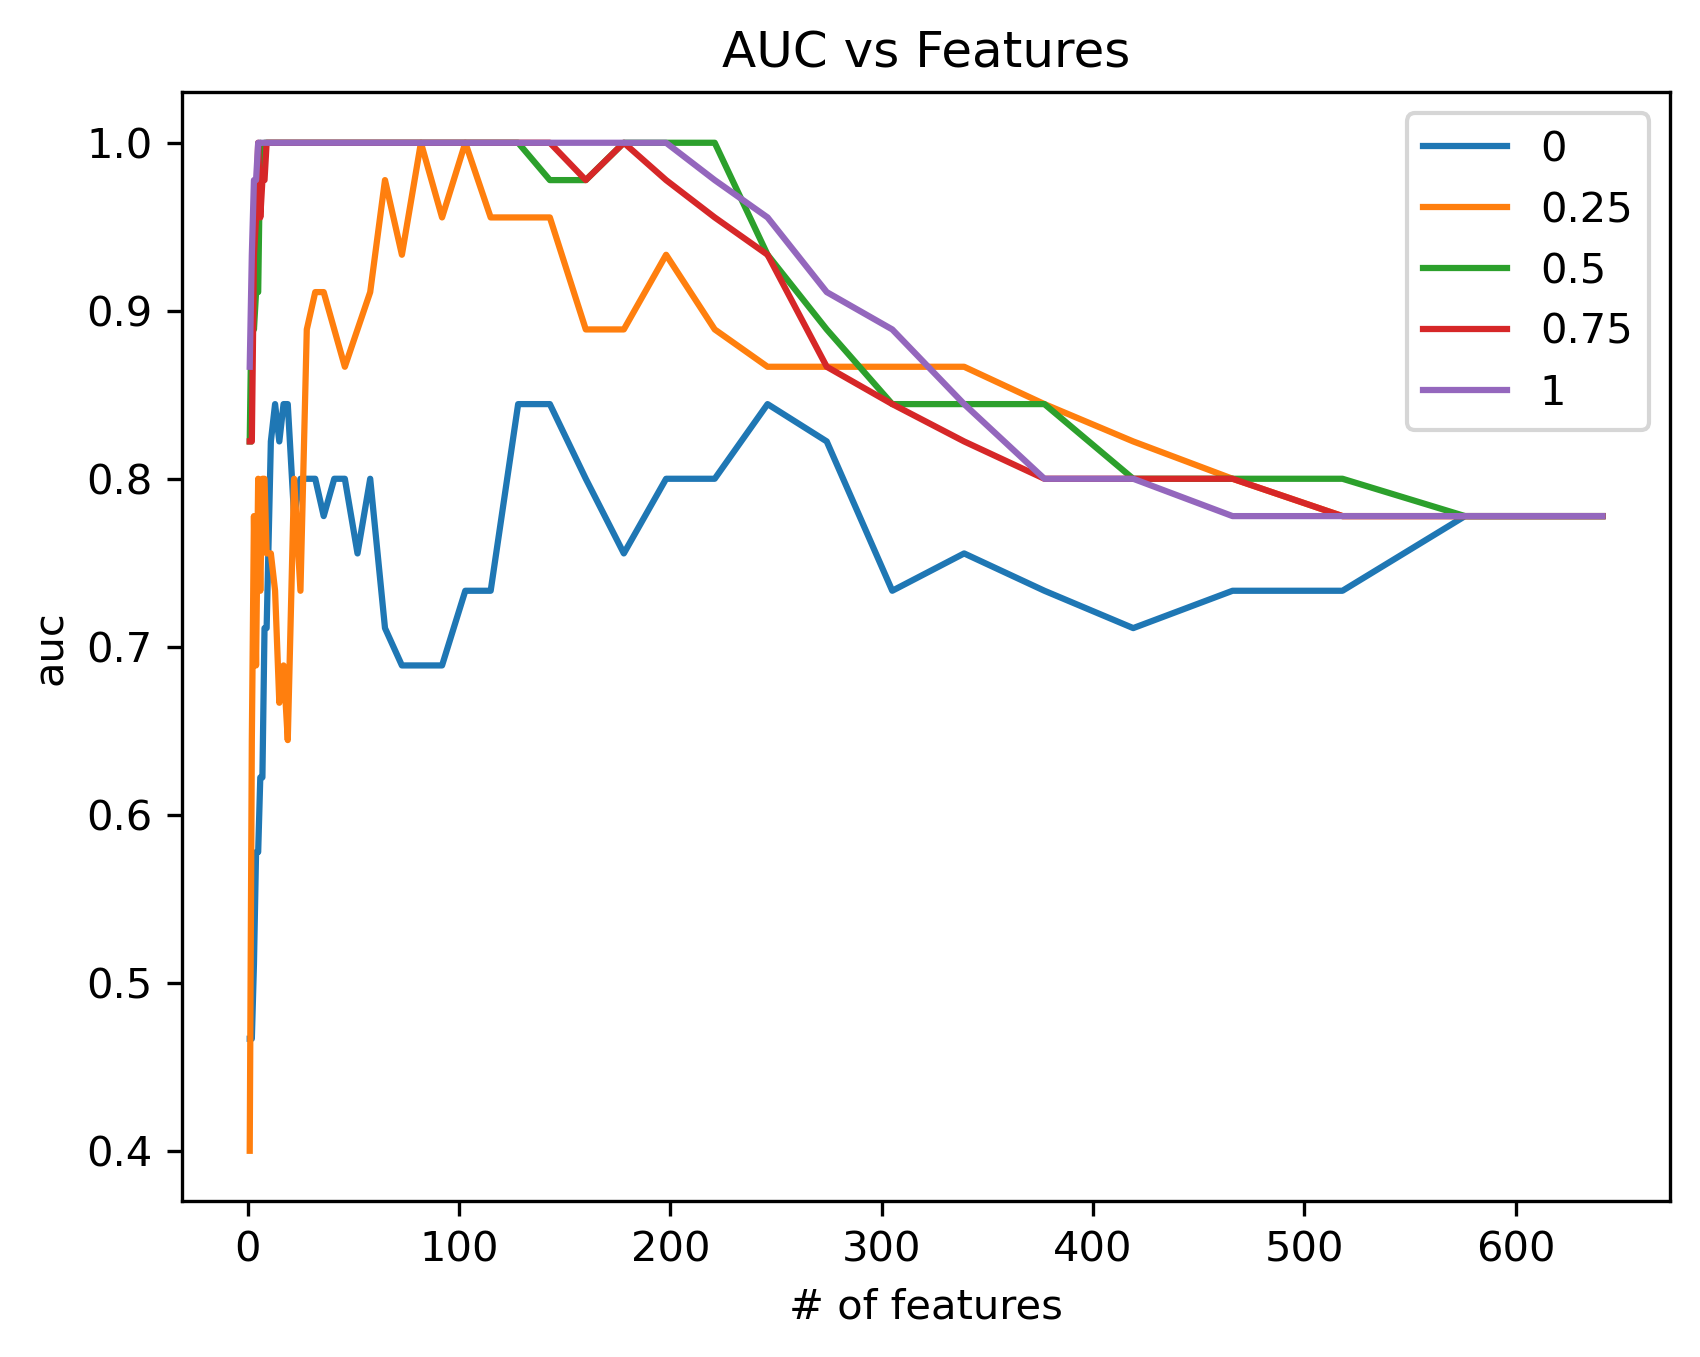

In [91]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

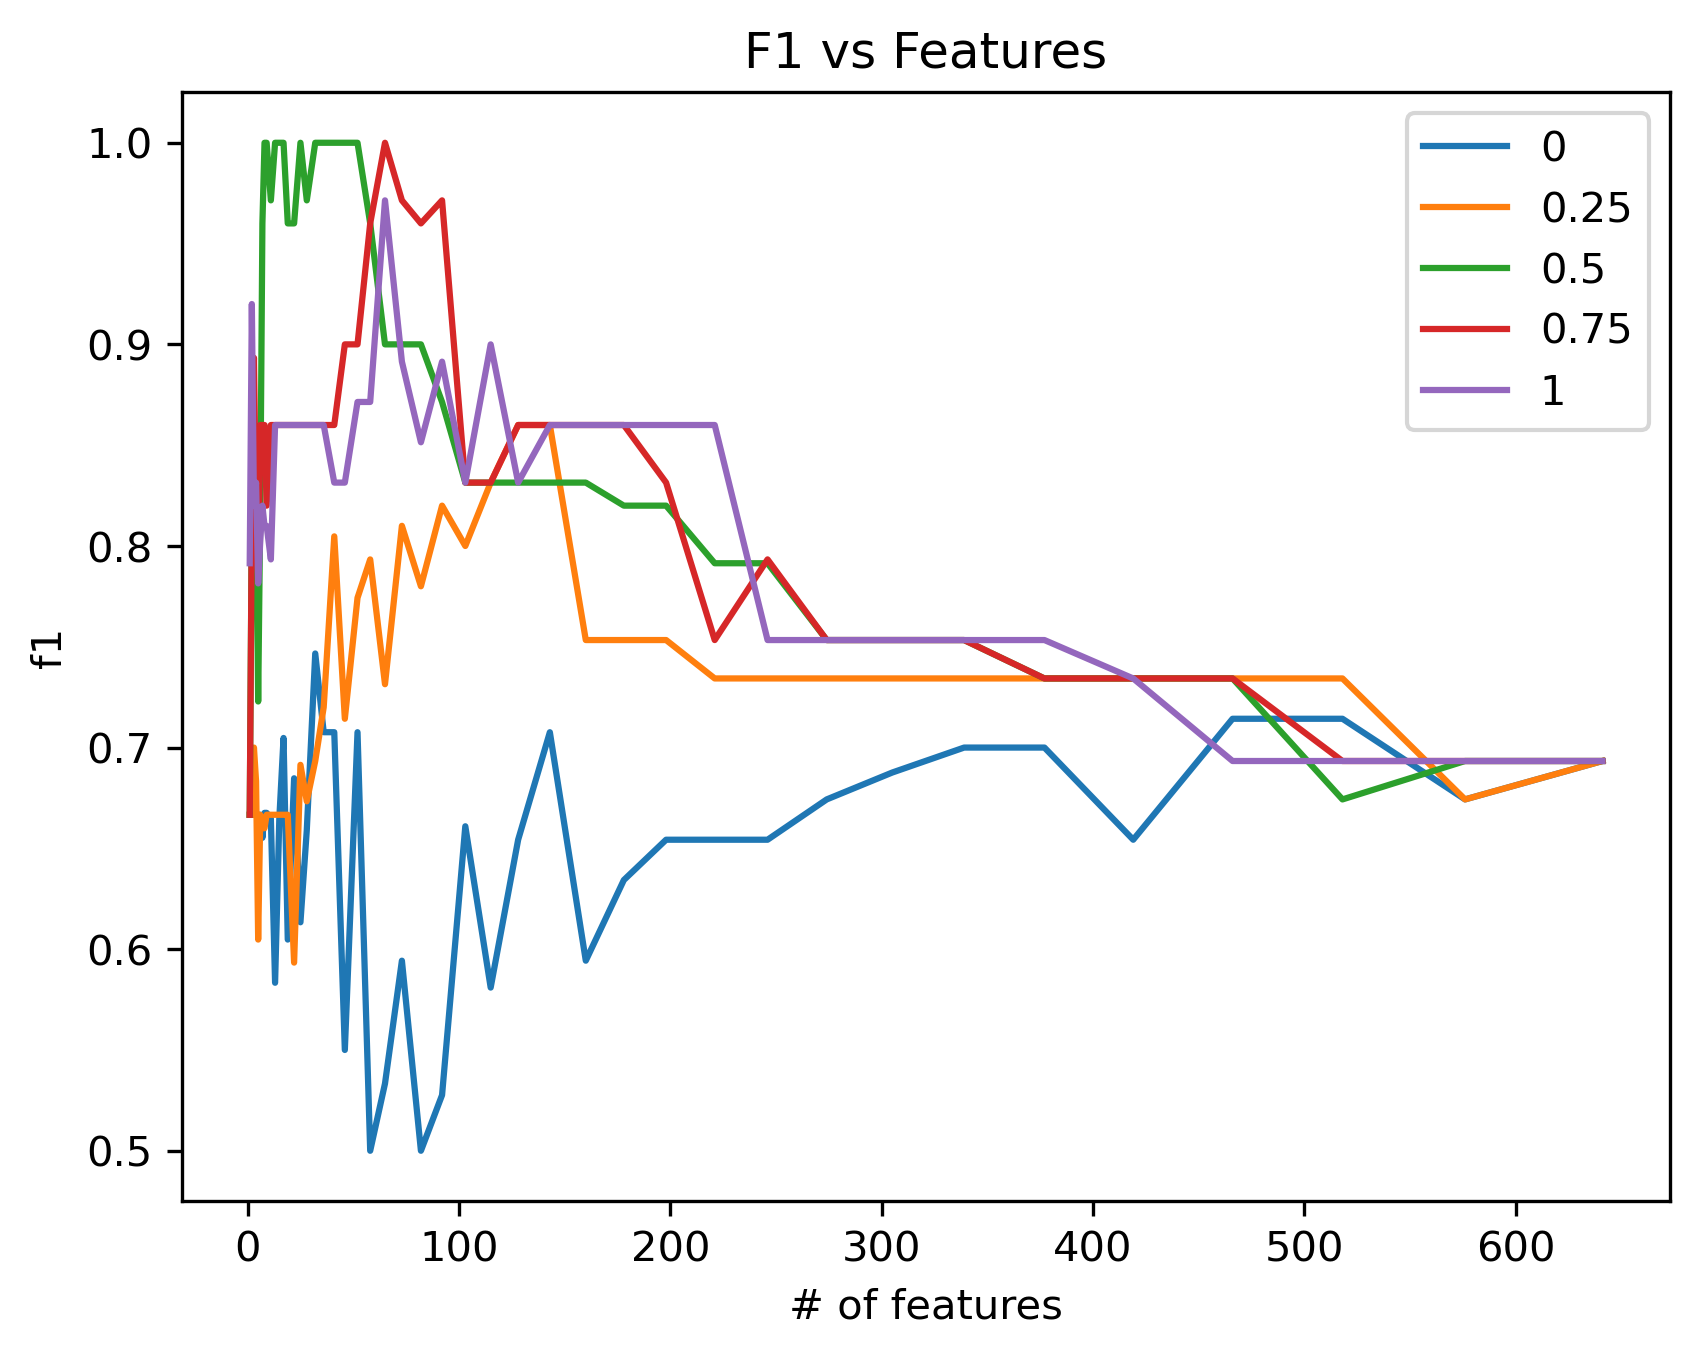

In [92]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

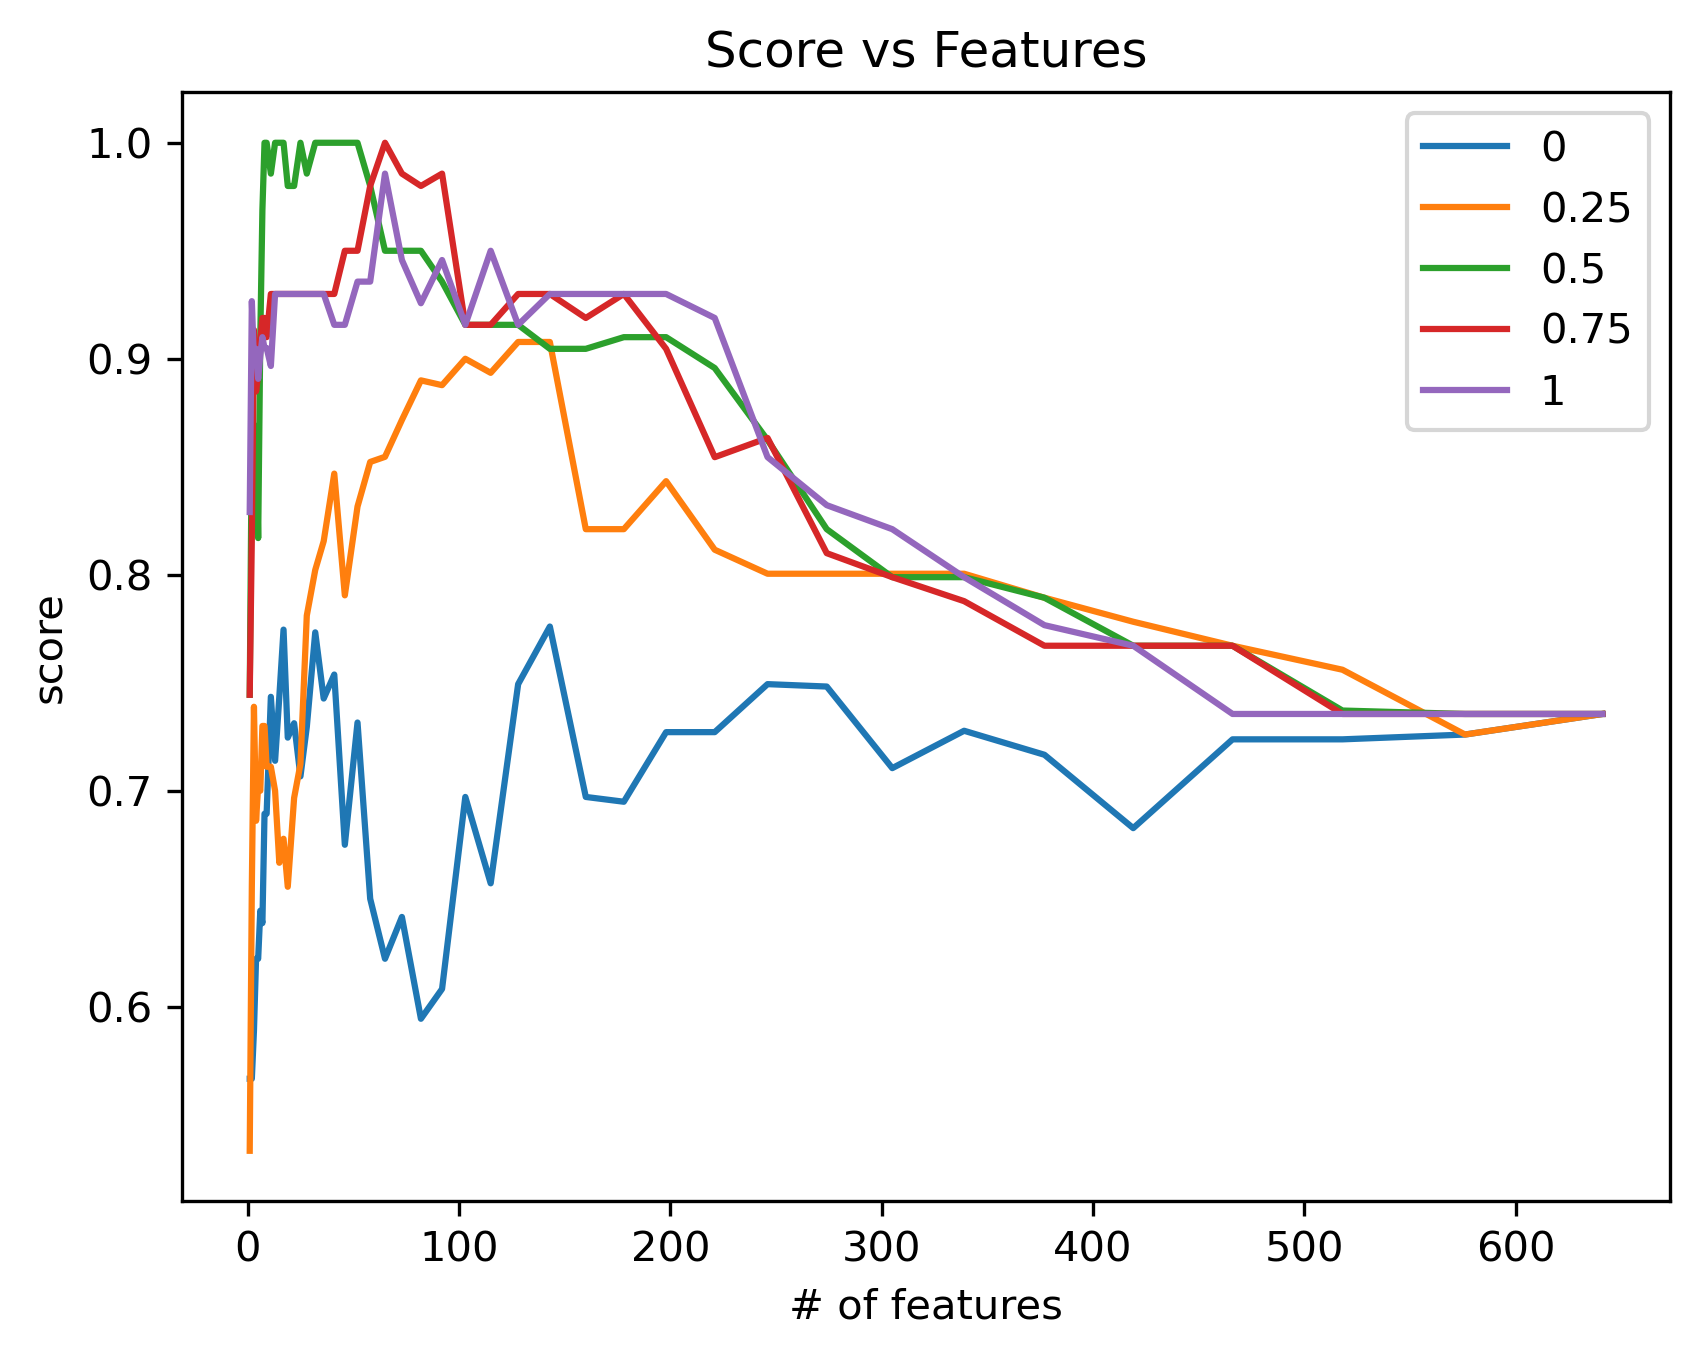

In [93]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

In [94]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "auc"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.7130985191788625,
 0.7929525419112002,
 0.8299705321546196,
 0.8253599286828618,
 0.8267793997474185]

In [95]:
svm_set_ranks[selected_run].performance_

{'f1': 1.0,
 'auc': 1.0,
 'score': 1.0,
 'C': 0.5,
 'num_features': 8,
 'mean_nSV': 10.8}

In [96]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [97]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [98]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


In [99]:
df_blindprediction

,f1,auc,true neg,false pos,false neg,true pos,precision or PPV,recall or TPR,specificity or TNR
0,0.571429,0.9,4.0,1.0,2.0,2.0,0.666667,0.50,0.8
0.25,0.666667,0.9,3.0,2.0,1.0,3.0,0.600000,0.75,0.6
0.5,1.000000,1.0,5.0,0.0,0.0,4.0,1.000000,1.00,1.0
0.75,0.857143,1.0,5.0,0.0,1.0,3.0,1.000000,0.75,1.0
1,0.857143,1.0,5.0,0.0,1.0,3.0,1.000000,0.75,1.0


In [100]:
df_performance

,f1,auc,score,C,num_features,mean_nSV
0,0.707619,0.844444,0.776032,0.062500,143.0,22.6
0.25,0.860000,0.955556,0.907778,0.125000,128.0,21.6
0.5,1.000000,1.000000,1.000000,0.500000,8.0,10.8
0.75,1.000000,1.000000,1.000000,0.015625,65.0,23.2
1,0.971429,1.000000,0.985714,0.007812,65.0,23.4


In [101]:
df_features

,0,0.25,0.5,0.75,1
0,Sex_female,Age,Creatinine Result(mg/dL) Desc 25%,Dx_other,BUN Result(mg/dL) Desc 50%
1,Sex_male,ALT Result(U/L) Desc mean,RBC Result Desc min,ALT Result(U/L) Desc 50%,Beta-2-Microglobulin Result Desc min
2,Age,ALT Result(U/L) Desc std,Beta-2-Microglobulin Result Exp intercpet,ALT Result(U/L) Desc max,Beta-2-Microglobulin Result Desc 75%
3,ALT Result(U/L) Desc mean,ALT Result(U/L) Desc min,Chloride Result(mmol/L) Exp R2,BUN Result(mg/dL) Desc min,Chloride Result(mmol/L) Desc mean
4,ALT Result(U/L) Desc std,ALT Result(U/L) Desc 25%,MCV Result Exp coef,BUN Result(mg/dL) Desc 50%,Chloride Result(mmol/L) Desc 25%
...,...,...,...,...,...
138,WBC Result(k/uL) Exp R2,NaN,NaN,NaN,NaN
139,total CO2 Result Exp residual error,NaN,NaN,NaN,NaN
140,NT Pro BNP (B-Type Natriuretic Peptide) Exp R2,NaN,NaN,NaN,NaN
141,NT Pro BNP (B-Type Natriuretic Peptide) Exp re...,NaN,NaN,NaN,NaN


## pair plots

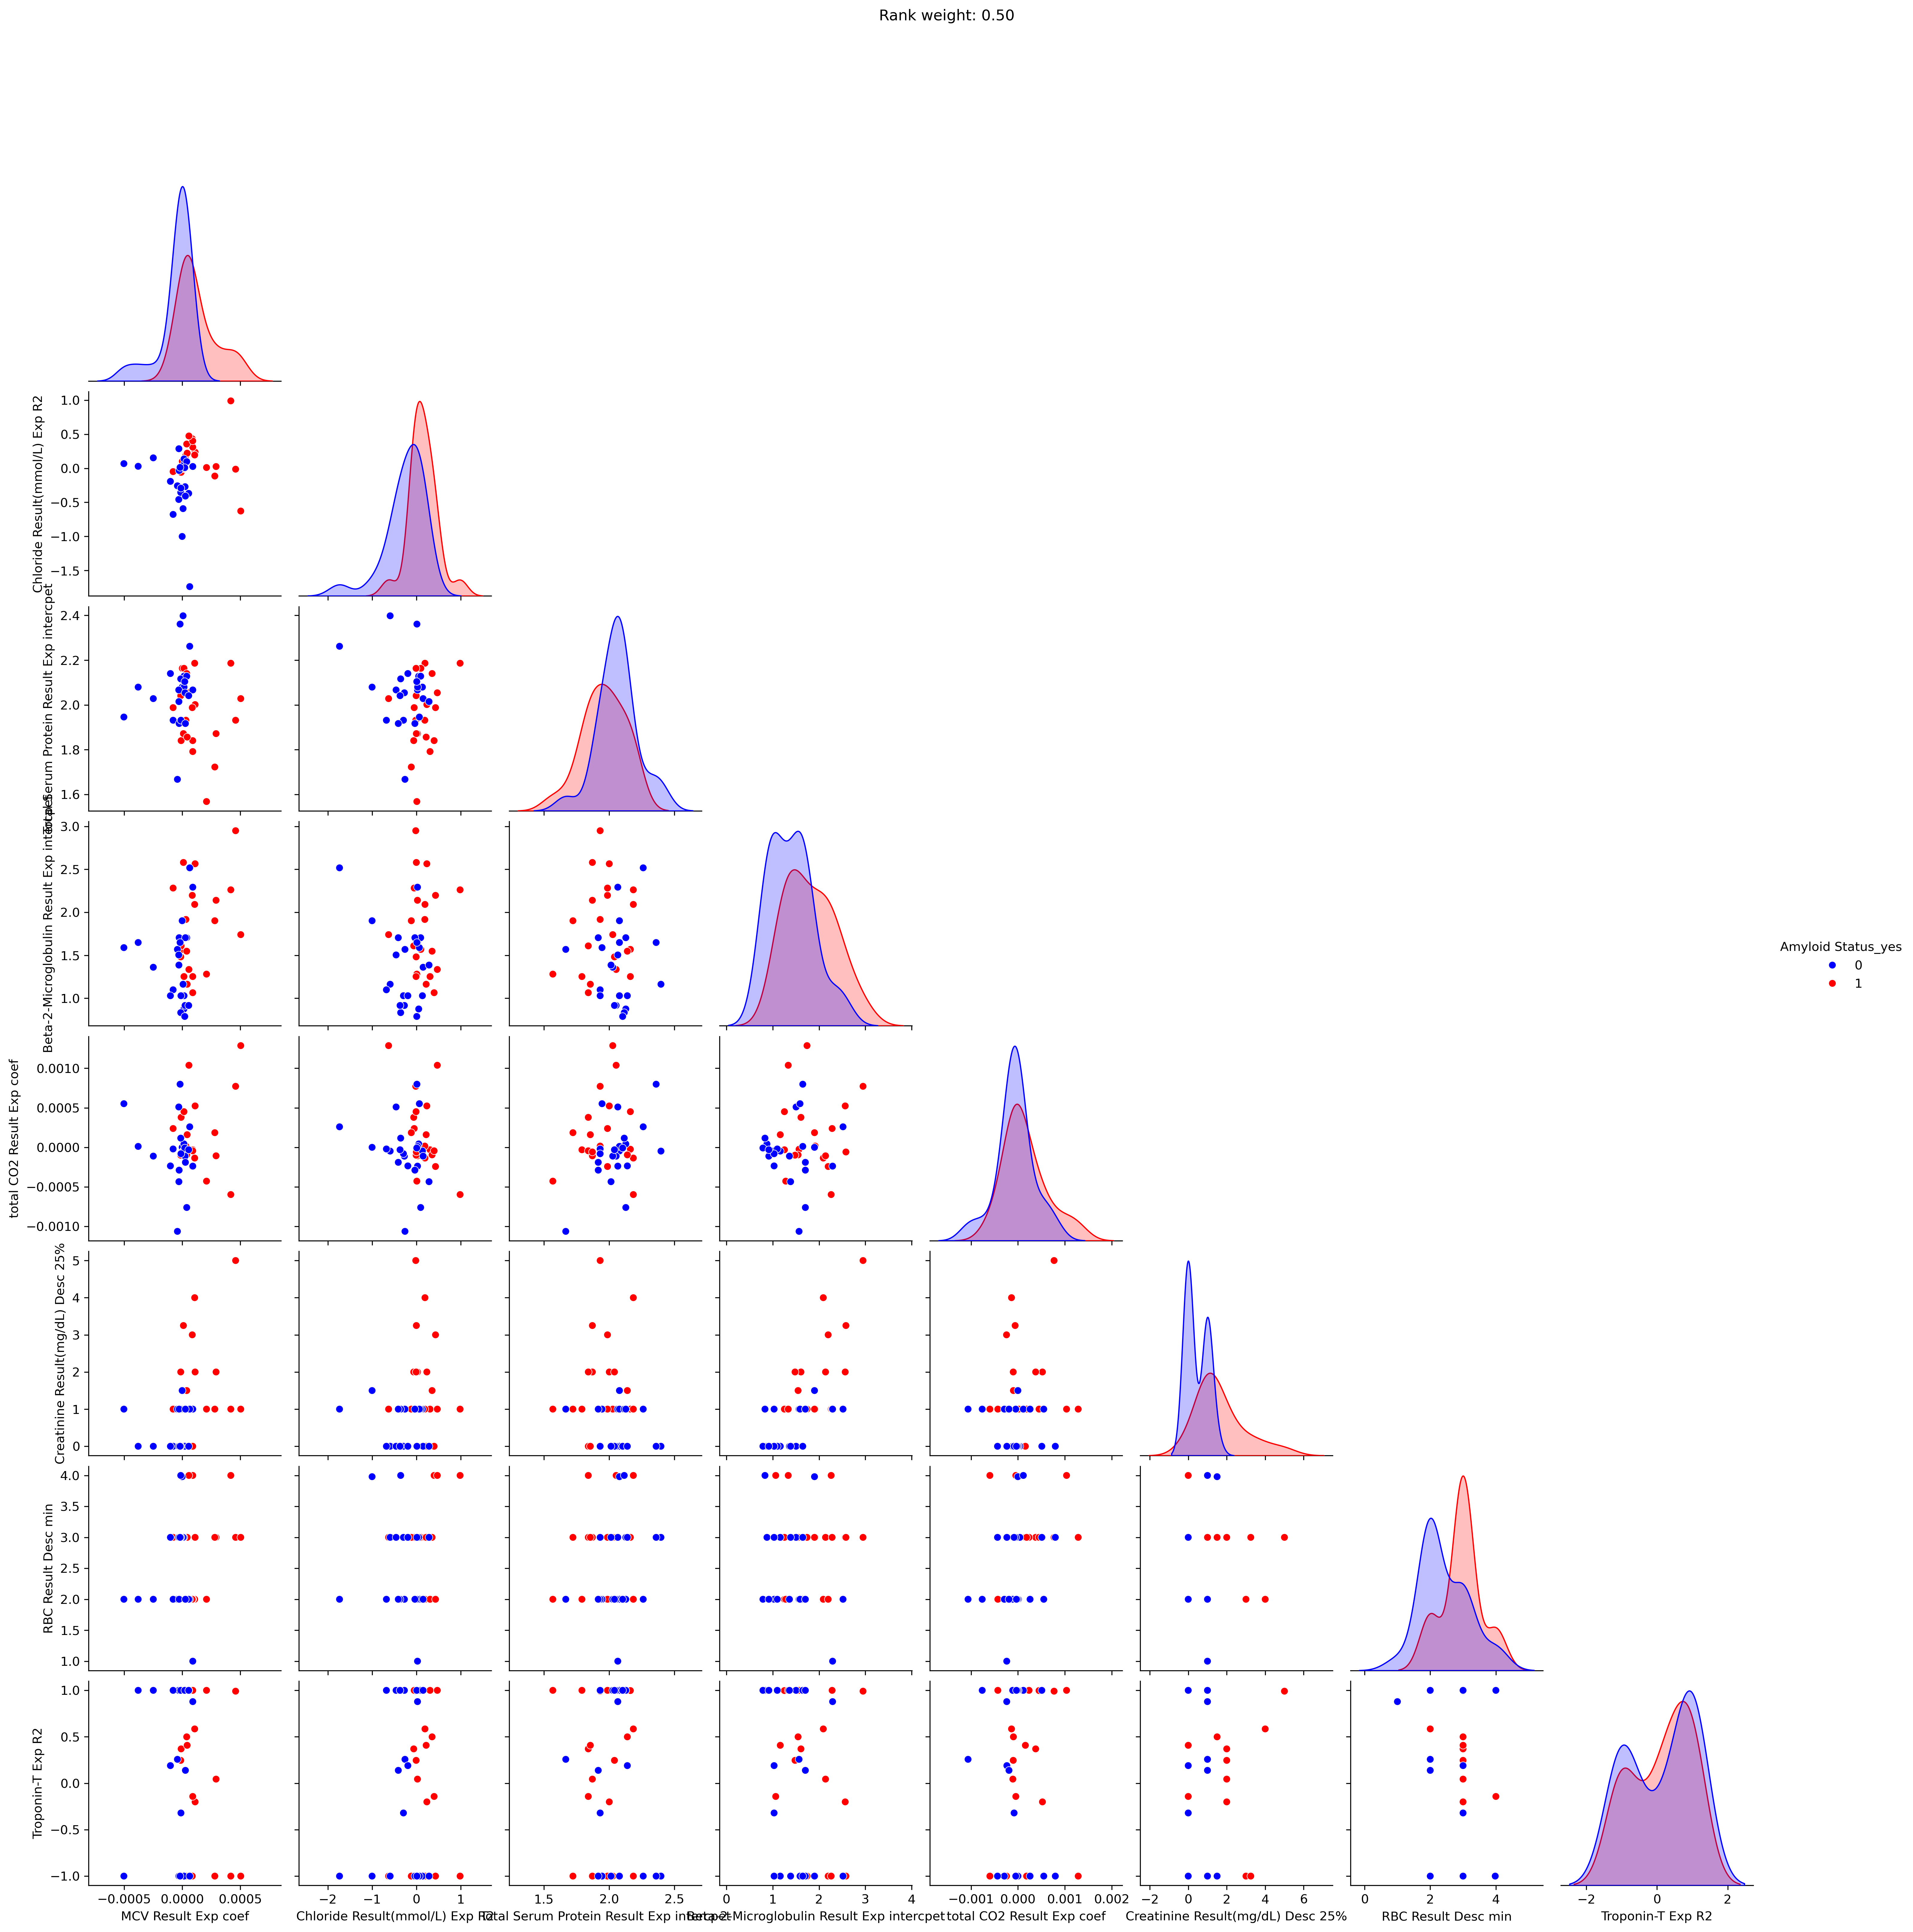

In [102]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

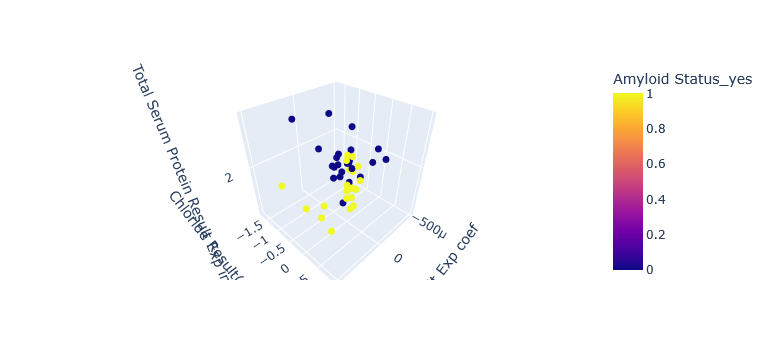

In [103]:
top3_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:3]].values
fig = px.scatter_3d(dataTable, x=top3_features[0], y=top3_features[1], z=top3_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

In [104]:
IG = svm_set_ranks[selected_run].integrated_gradient(X_all)
IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

features = svm_set_ranks[selected_run].features
IG_X = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
#IG_X = X.iloc[:,features]
N = len(IGtable)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



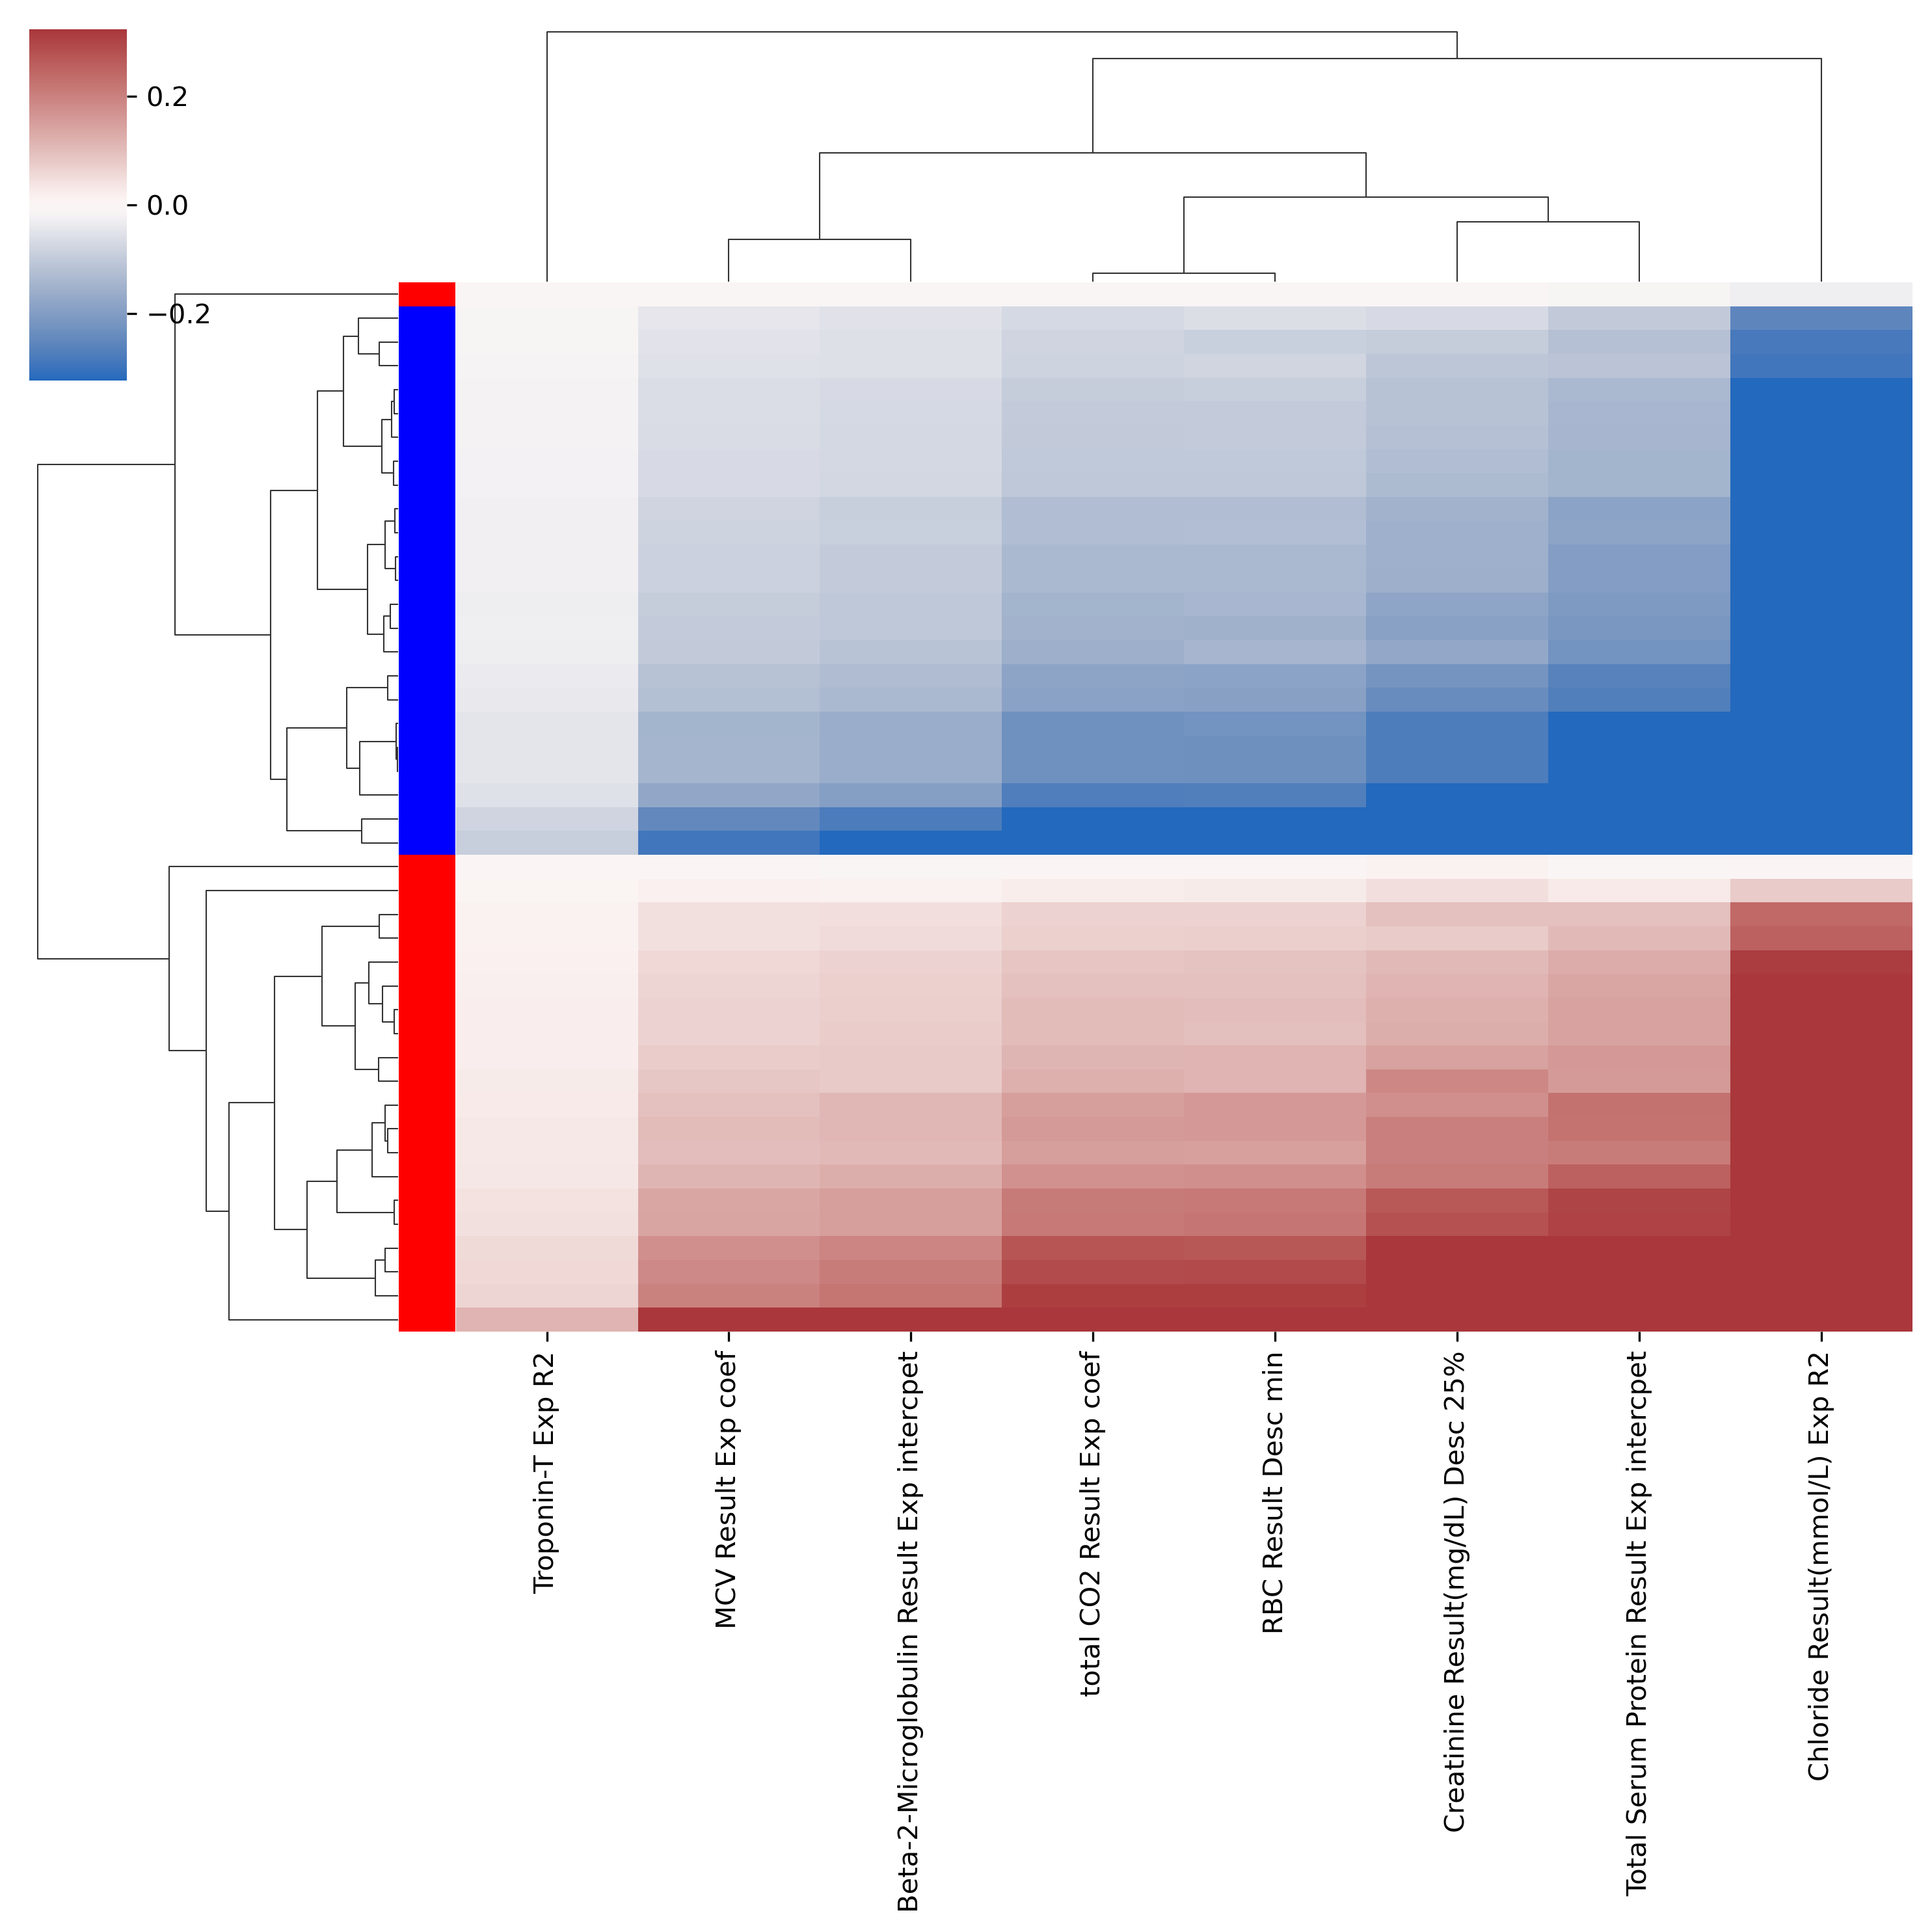

In [105]:
from seaborn import pairplot, clustermap, load_dataset
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_all])

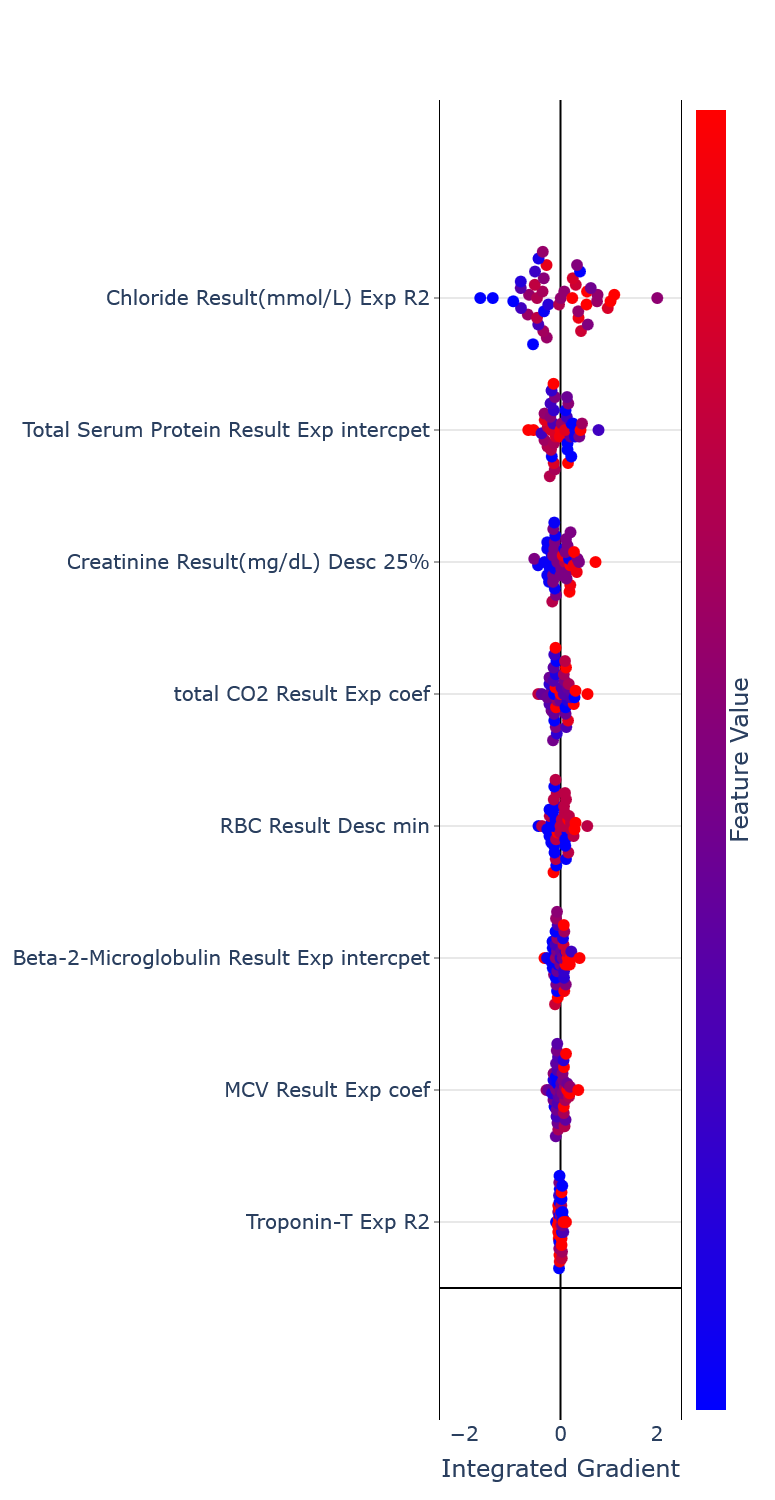

In [106]:
import plotly.graph_objects as go
import plotly.express as px

nbins = 10
scale = 0.1
n_features = 8
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=1500,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()
#saving figure
figCommon = fileName_common + "_SHAP"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')
fig.write_html("012 Processed Data/Mistic2_descFits_linear_250127_v1/Mistic2_descFits_linear_SHAP_250127_v1.html")

In [107]:
# figPath

In [108]:
# fig.write_image('012 Processed Data/Mistic2_descFits_linear_250127_v1/Mistic2_descFits_linear_SHAP_250127_v1.pdf')

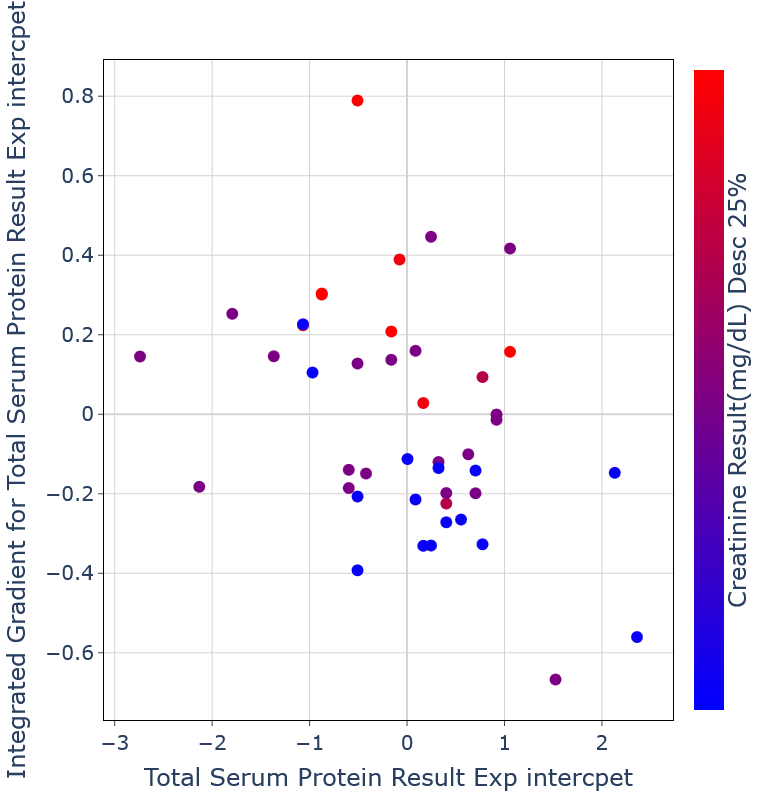

In [109]:
feat_1 = IGtable.columns[feature_order[6]]
feat_2 = IGtable.columns[feature_order[5]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

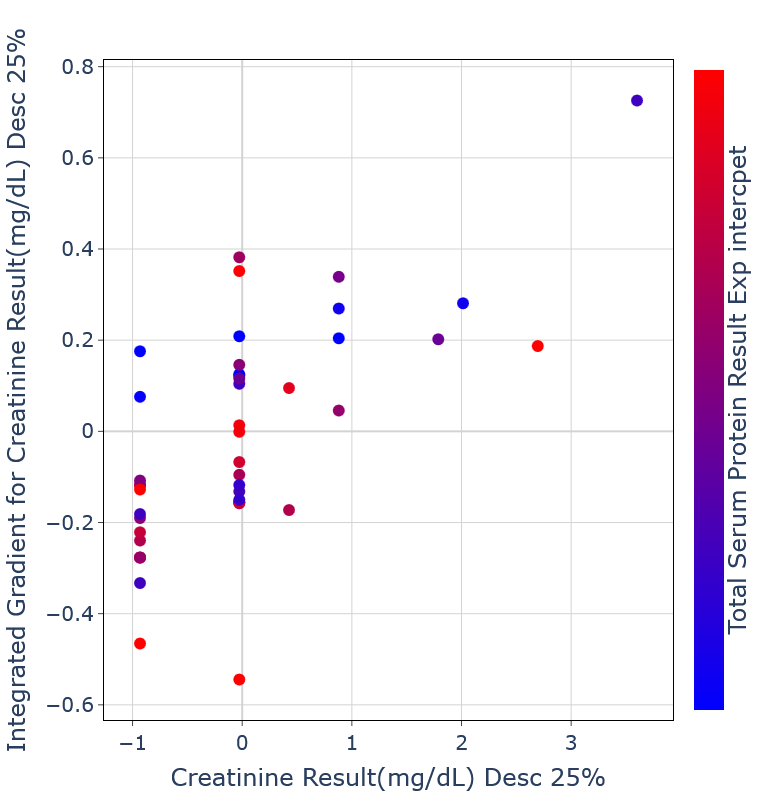

In [110]:
feat_1 = IGtable.columns[feature_order[5]]
feat_2 = IGtable.columns[feature_order[6]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

# sensitivity and specificity 

In [111]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

print("True Negative: ", tn)
print("false positive: ", fp)
print("false negative: ", fn)
print("true positive: ", tp)
print("true positive rate or recall/sensitivity: ", recall)
print("positive predictive value or precision: ", precision)
print("specificity or true negatie rate: ", specificity)
print("auc: ", auc)
print("f1 score: ", f1)

True Negative:  5
false positive:  0
false negative:  0
true positive:  4
true positive rate or recall/sensitivity:  1.0
positive predictive value or precision:  1.0
specificity or true negatie rate:  1.0
auc:  1.0
f1 score:  1.0


# testing alternative models using only the best performing features

In [112]:
# Import dataset
dataTable = pd.read_excel(dataFileName, header = 0) #the dataset we are using

#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'Amyloid Status_yes', 'Amyloid Status_no', "Amyloid Status_unk"]
x_columns_toKeep = list(X.columns[svm_set_ranks[selected_run].features])
x_columns_toDrop = list(set(dataTable.columns)-set(x_columns_toKeep))

#columns to use for the y data 
y_column_Classification = 'Amyloid Status_yes'

X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)

binary_feats = []
for col in X.columns:
    unique_values = X[col].unique()
    if len(unique_values) == 2:
        binary_feats.append(X.columns.get_loc(col))
# X.iloc[:,binary_feats]    

In [113]:
# scaler = StandardScaler()
# scaler.fit(X)

# X_all = scaler.transform(X)
x_columns_toDrop = list(set(X_all.columns)-set(x_columns_toKeep))
X_all = X_all.drop(columns=x_columns_toDrop,inplace=True) #already scalled 
y_all = dataTable[y_column_Classification]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= 0, 
                                                    test_size= test_size_numb)

max(X_all[:,0])

1.3228756555322954

In [114]:
df_x_train = pd.DataFrame(X_train)
print(type(df_x_train))

<class 'pandas.core.frame.DataFrame'>


In [115]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

In [116]:
# making a set of other models to test....

In [ ]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = 'binary'))

0.9
[0.88888889 0.88888889]


In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = 'binary'))

0.7750000000000001
[0.8  0.75]


In [ ]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = 'binary'))

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 17, number of negative: 18
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485714 -> initscore=-0.057158
[LightGBM] [Info] Start training from score -0.057158
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

In [120]:
# from pytorch_tabnet.tab_model import TabNetClassifier
# import torch

# # define the model
# clf= TabNetClassifier(optimizer_fn=torch.optim.Adam,
#                        scheduler_params={"step_size":10, 
#                                          "gamma":0.9},
#                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
#                       )

# # fit the model 
# clf.fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_test, y_test)],
#     eval_name=['train', 'test'],
#     eval_metric=['auc','balanced_accuracy'],
#     max_epochs=200, patience=60,
#     batch_size=512, virtual_batch_size=512,
#     num_workers=0,
#     weights=1,
#     drop_last=False
# )            